# London Lockdown Multilevel Model

## Load Data

In [1]:
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

warnings.simplefilter('ignore', ConvergenceWarning)

DATA_DIR = Path("C:\\Users\\Andrew\\OneDrive - University College London\\_PhD\\Papers - Drafts\\J5_JASA_Lockdown-SS\\data")
ssidData = pd.read_csv(DATA_DIR.joinpath("2020-08-13\\LondonVeniceBINResults_2020-08-13_4.csv"))
ssidData.head()

,Unnamed: 0,GroupID,SessionID,LocationID,record_id,recording,start_time,end_time,latitude,longitude,...,THD_5,THD_10,THD_50,THD_90,THD_95,THD_Min,THD_Max,THD_5_THD_95,THD_10_THD_90,THD_Max_THD_Min
0,0,CT101,CamdenTown1,CamdenTown,525.0,11-42_1,2019-05-02 11:40,2019-05-02 11:43,51.539124,-0.142624,...,3.13,2.33,-0.45,-4.52,-5.58,-10.77,5.45,8.71,6.85,16.22
1,1,CT101,CamdenTown1,CamdenTown,526.0,11-42_1,2019-05-02 11:41,2019-05-02 11:44,51.539124,-0.142624,...,3.13,2.33,-0.45,-4.52,-5.58,-10.77,5.45,8.71,6.85,16.22
2,2,CT101,CamdenTown1,CamdenTown,561.0,11-42_1,2019-05-02 11:40,2019-05-02 11:43,NaN,NaN,...,3.13,2.33,-0.45,-4.52,-5.58,-10.77,5.45,8.71,6.85,16.22
3,3,CT102,CamdenTown1,CamdenTown,560.0,11-50_2,2019-05-02 11:50,2019-05-02 11:53,NaN,NaN,...,3.09,2.52,0.28,-2.39,-3.37,-7.04,5.72,6.46,4.91,12.76
4,4,CT103,CamdenTown1,CamdenTown,527.0,11-52_3,2019-05-02 11:49,2019-05-02 11:54,51.539124,-0.142624,...,3.16,2.40,-0.15,-3.17,-4.15,-7.91,5.59,7.31,5.57,13.50


## Reshape, standardise, and filter the data

In [2]:
for col_name in ["Lockdown"]:
    ssidData[col_name] = ssidData[col_name].astype('category')

acoustic_vars = ["FS", "FS_5", "FS_10", "FS_50", "FS_90", "FS_95", "FS_Min", "FS_Max", "FS_5_FS_95", "FS_10_FS_90", "FS_Max_FS_Min", "LAeq", "LAeq_5", "LAeq_10", "LAeq_50", "LAeq_90", "LAeq_95", "LAeq_Max", "LAeq_Min", "LAeq_10_LAeq_90", "LAeq_5_LAeq_95", "LAeq_Max_LAeq_Min", "N_5", "N_10", "N_50", "N_90", "N_95", "N_Min", "N_Max", "N_5_N_95", "N_10_N_90", "N_Max_N_Min", "R", "R_5", "R_10", "R_50", "R_90", "R_95", "R_Min", "R_Max", "R_5_R_95", "R_10_R_90", "R_Max_R_Min", "S", "S_5", "S_10", "S_50", "S_90", "S_95", "S_Min", "S_Max", "S_5_S_95", "S_10_S_90", "S_Max_S_Min", "SIL_5", "SIL_10", "SIL_50", "SIL_90", "SIL_95", "SIL_Min", "SIL_Max", "SIL_5_SIL_95", "SIL_10_SIL_90", "SIL_Max_SIL_Min", "T_5", "T_10", "T_50", "T_90", "T_95", "T_Max", "T_5_T_95", "T_10_T_90", "SpectralCentroid", "MaxFreq", "PeakSpectralCentroid", "PeakMaxFreq", "I","I_5","I_10","I_50","I_90","I_95","I_Min","I_Max","I_5_I_95","I_10_I_90","I_Max_I_Min", "LCeq","LCeq_5","LCeq_10","LCeq_50","LCeq_90","LCeq_95","LCeq_Min","LCeq_Max","LCeq_5_LCeq_95","LCeq_10_LCeq_90","LCeq_Max_LCeq_Min", "LZeq","LZeq_5","LZeq_10","LZeq_50","LZeq_90","LZeq_95","LZeq_Min","LZeq_Max","LZeq_5_LZeq_95","LZeq_10_LZeq_90","LZeq_Max_LZeq_Min", "THD_5","THD_10","THD_50","THD_90","THD_95","THD_Min","THD_Max", "THD_5_THD_95","THD_10_THD_90","THD_Max_THD_Min"]

# "FS_M0", "FS_nrmse0", "LAeq_M0", "LAeq_nrmse0", "N_M0", "N_nrmse0", "N_M1", "N_nrmse1", "N_M2", "N_nrmse2", "R_M0", "R_nrmse0", "S_M0", "S_nrmse0", "S_M1", "S_nrmse1", "S_M2", "S_nrmse2", "SIL_M0", "SIL_nrmse0", "T_M0", "T_nrmse0",

dep_vars = ["loudness", "Natural", "Traffic", "Human", "Other", "overall", "Pleasant", "Eventful"]

# Cutdown the dataset
cols = ["GroupID", "LocationID", "SessionID", "Lockdown"] + dep_vars + acoustic_vars
ssidData = ssidData[cols]

# Compress to mean of each GroupID
# compressData = ssidData.copy()
compressData = ssidData.groupby(["GroupID"]).mean()
compressData = compressData.merge(ssidData[["GroupID", "LocationID", "SessionID", "Lockdown"]].drop_duplicates(),  on="GroupID")

location_codes = pd.Categorical(compressData["LocationID"]).codes
compressData["LocationID_codes"] = location_codes
compressData.loc[compressData["Lockdown"] == 1].dropna(inplace=True)
compressData = compressData.dropna(subset=acoustic_vars)

print(compressData.shape)
compressData.head()


(1235, 132)


,GroupID,loudness,Natural,Traffic,Human,Other,overall,Pleasant,Eventful,FS,...,THD_95,THD_Min,THD_Max,THD_5_THD_95,THD_10_THD_90,THD_Max_THD_Min,LocationID,SessionID,Lockdown,LocationID_codes
1,AM02,3.500000,3.500000,2.000000,4.0,1.500000,4.500000,0.426777,0.000000,0.0215,...,2.31,-1.18,9.11,4.80,3.64,10.29,SanMarco,SanMarco1,1,8
4,AM06,2.500000,1.500000,1.000000,3.5,4.000000,3.000000,0.176777,0.103553,0.0283,...,1.17,-3.63,7.73,4.59,3.50,11.36,SanMarco,SanMarco1,1,8
5,AM07,3.000000,4.000000,1.000000,4.0,1.000000,5.000000,0.707107,0.707107,0.0178,...,1.59,-0.77,9.20,5.28,4.15,9.97,SanMarco,SanMarco1,1,8
6,CT101,3.333333,1.666667,3.666667,3.0,2.333333,2.666667,-0.229780,0.284518,0.0170,...,-5.58,-10.77,5.45,8.71,6.85,16.22,CamdenTown,CamdenTown1,1,0
7,CT102,3.000000,1.000000,3.000000,4.0,2.000000,2.000000,0.103553,-0.750000,0.0179,...,-3.37,-7.04,5.72,6.46,4.91,12.76,CamdenTown,CamdenTown1,1,0


In [3]:
def nonlinear_features(data, features, transformations = ["sqrt", "square"]):
    new_acoustic_vars = []
    for feature in features:
        new_acoustic_vars.append(feature)
        if feature in ["FS_5_FS_95", "FS_10_FS_90", "FS_Max_FS_Min", 
                        "LAeq_5_LAeq_90", "LAeq_10_LAeq_90", "LAeq_Max_LAeq_Min", 
                        "N_5_N_95", "N_10_N_90", "N_Max_N_Min",
                        "R_5_R_95", "R_10_R_90", "R_Max_R_Min",
                        "S_5_S_95", "S_10_S_90", "S_Max_S_Min",
                        "SIL_5_SIL_95", "SIL_10_SIL_90", "SIL_Max_SIL_Min",
                        "T_5_T_95", "T_10_T_90",
                        "LZeq_5_LZeq_95", "LZeq_10_LZeq_90", "LZeq_Max_LZeq_Min",
                        "LCeq_5_LCeq_95", "LCeq_10_LCeq_90", "LCeq_Max_LCeq_Min",
                        "THD_5_THD_95", "THD_10_THD_90", "THD_Max_THD_Min"
                        ]:
            continue
        if "THD" in feature:
            continue

        for transform in transformations:
            if transform == "log":
                transform_feature = f"log_{feature}"
                transform_val = np.log(data[feature])
            elif transform == "square":
                transform_feature = f"sq_{feature}"
                transform_val = np.square(data[feature])
            elif transform == "sqrt":
                if any(data[feature]) < 0:
                    break
                else:
                    transform_feature = f"sqrt_{feature}"
                    transform_val = np.sqrt(data[feature])
            else:
                print(f"Transformation not recognised: {transform}")
                continue
            
            if not transform_val.isnull().values.all():
                data[transform_feature] = transform_val
                new_acoustic_vars.append(transform_feature)

    return data, new_acoustic_vars

# compressData, acoustic_vars = nonlinear_features(compressData, acoustic_vars, transformations=["log", "square"])
# print(acoustic_vars)
# compressData.head()


In [4]:
# Standardise
from sklearn.preprocessing import StandardScaler
compressData = compressData.replace([np.inf, -np.inf], np.nan)
compressData = compressData.dropna(subset=acoustic_vars)
scaler = StandardScaler()
compressData[acoustic_vars] = scaler.fit_transform(compressData[acoustic_vars])
print(compressData.shape)
compressData.head()


(1235, 132)


,GroupID,loudness,Natural,Traffic,Human,Other,overall,Pleasant,Eventful,FS,...,THD_95,THD_Min,THD_Max,THD_5_THD_95,THD_10_THD_90,THD_Max_THD_Min,LocationID,SessionID,Lockdown,LocationID_codes
1,AM02,3.500000,3.500000,2.000000,4.0,1.500000,4.500000,0.426777,0.000000,0.413252,...,2.566332,2.106882,2.356468,-1.354183,-1.241168,-1.207217,SanMarco,SanMarco1,1,8
4,AM06,2.500000,1.500000,1.000000,3.5,4.000000,3.000000,0.176777,0.103553,0.855149,...,2.060710,1.280499,1.337084,-1.490843,-1.350337,-0.784567,SanMarco,SanMarco1,1,8
5,AM07,3.000000,4.000000,1.000000,4.0,1.000000,5.000000,0.707107,0.707107,0.172807,...,2.246992,2.245174,2.422950,-1.041815,-0.843478,-1.333617,SanMarco,SanMarco1,1,8
6,CT101,3.333333,1.666667,3.666667,3.0,2.333333,2.666667,-0.229780,0.284518,0.120819,...,-0.933104,-1.127816,-0.347116,1.190311,1.261934,1.135135,CamdenTown,CamdenTown1,1,0
7,CT102,3.000000,1.000000,3.000000,4.0,2.000000,2.000000,0.103553,-0.750000,0.179306,...,0.047093,0.130309,-0.147671,-0.273912,-0.250844,-0.231566,CamdenTown,CamdenTown1,1,0


Split into pre- and during-lockdown datasets

In [5]:
prelockdownData = compressData.loc[compressData["Lockdown"] == 1]
prelockdownData = prelockdownData.dropna()
print(prelockdownData.shape)
prelockdownData.head()

(661, 132)


,GroupID,loudness,Natural,Traffic,Human,Other,overall,Pleasant,Eventful,FS,...,THD_95,THD_Min,THD_Max,THD_5_THD_95,THD_10_THD_90,THD_Max_THD_Min,LocationID,SessionID,Lockdown,LocationID_codes
1,AM02,3.500000,3.500000,2.000000,4.0,1.500000,4.500000,0.426777,0.000000,0.413252,...,2.566332,2.106882,2.356468,-1.354183,-1.241168,-1.207217,SanMarco,SanMarco1,1,8
4,AM06,2.500000,1.500000,1.000000,3.5,4.000000,3.000000,0.176777,0.103553,0.855149,...,2.060710,1.280499,1.337084,-1.490843,-1.350337,-0.784567,SanMarco,SanMarco1,1,8
5,AM07,3.000000,4.000000,1.000000,4.0,1.000000,5.000000,0.707107,0.707107,0.172807,...,2.246992,2.245174,2.422950,-1.041815,-0.843478,-1.333617,SanMarco,SanMarco1,1,8
6,CT101,3.333333,1.666667,3.666667,3.0,2.333333,2.666667,-0.229780,0.284518,0.120819,...,-0.933104,-1.127816,-0.347116,1.190311,1.261934,1.135135,CamdenTown,CamdenTown1,1,0
7,CT102,3.000000,1.000000,3.000000,4.0,2.000000,2.000000,0.103553,-0.750000,0.179306,...,0.047093,0.130309,-0.147671,-0.273912,-0.250844,-0.231566,CamdenTown,CamdenTown1,1,0


In [6]:
lockdownData = compressData.loc[compressData["Lockdown"] == 2]
print(lockdownData.shape)
lockdownData.head() 

(573, 132)


,GroupID,loudness,Natural,Traffic,Human,Other,overall,Pleasant,Eventful,FS,...,THD_95,THD_Min,THD_Max,THD_5_THD_95,THD_10_THD_90,THD_Max_THD_Min,LocationID,SessionID,Lockdown,LocationID_codes
63,CT501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.529030,...,-0.454094,-0.861350,1.019450,0.175117,-0.414598,1.553835,CamdenTown,CamdenTown5,2,0
64,CT502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.557624,...,-2.241511,-1.826025,-0.147671,3.188161,3.219189,2.059436,CamdenTown,CamdenTown5,2,0
65,CT503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.080634,...,-0.347647,-0.652224,-0.147671,-0.391050,-0.500374,0.684835,CamdenTown,CamdenTown5,2,0
66,CT504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198801,...,0.406351,0.143801,-1.130121,-0.989754,-1.007233,-0.772717,CamdenTown,CamdenTown5,2,0
67,CT505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.243096,...,-0.671422,-0.625240,-0.036868,0.982066,0.614715,0.712485,CamdenTown,CamdenTown5,2,0


## Global Functions

In [7]:
def r_squared(model_fit, data):
    response = model_fit.model.formula.split()[0]
    y = data[response]
    y_predict = model_fit.fittedvalues
    RMSE = np.sqrt(((y - y_predict)**2).values.mean())
    Rsquared = 1.0 - (np.var(y - y_predict) / np.var(y))
    return Rsquared

def adjusted_r_squared(model_fit, data):
    response = model_fit.model.formula.split()[0]
    y = data[response]
    y_predict = model_fit.fittedvalues
    r_sq = r_squared(model_fit, data)
    adjusted_r_squared = 1 - (1 - r_sq) * (len(y)-1)/(len(y)-len(model_fit.fe_params)-1)
    return adjusted_r_squared

def max_pcor(feature_list, target_feature, covar, data):
    cors_table = pd.DataFrame()
    for feature in feature_list:
        par_cor = pg.partial_corr(data, x=feature, y = target_feature, covar=covar)
        cors_table[feature] = par_cor['r']
    
    cors_table = cors_table.T.squeeze()

    max_feature = cors_table.abs().idxmax()
    max_val = cors_table[max_feature]

    return max_feature, max_val

FS_stats = ["FS", "FS_5", "FS_10", "FS_50", "FS_90", "FS_95", "FS_Min", "FS_Max"]
FS_variation = ["FS_5_FS_95", "FS_10_FS_90", "FS_Max_FS_Min"]
LAeq_stats = ["LAeq", "LAeq_5", "LAeq_10", "LAeq_50", "LAeq_90", "LAeq_95", "LAeq_Max", "LAeq_Min"]
LAeq_variation = ["LAeq_10_LAeq_90", "LAeq_5_LAeq_95", "LAeq_Max_LAeq_Min"]
N_stats = ["N_5", "N_10", "N_50", "N_90", "N_95", "N_Min", "N_Max"]
N_variation = ["N_5_N_95", "N_10_N_90", "N_Max_N_Min"]
R_stats = ["R", "R_5", "R_10", "R_50", "R_90", "R_95", "R_Min", "R_Max"]
R_variation = ["R_5_R_95", "R_10_R_90", "R_Max_R_Min"]
S_stats = ["S", "S_5", "S_10", "S_50", "S_90", "S_95", "S_Min", "S_Max"]
S_variation = ["S_5_S_95", "S_10_S_90", "S_Max_S_Min"]
SIL_stats = ["SIL_5", "SIL_10", "SIL_50", "SIL_90", "SIL_95", "SIL_Min", "SIL_Max"]
SIL_variation = ["SIL_5_SIL_95", "SIL_10_SIL_90", "SIL_Max_SIL_Min"]
T_stats = ["T_5", "T_10", "T_50", "T_90", "T_95", "T_Max"]
T_variation = ["T_5_T_95", "T_10_T_90"]
I_stats = ["I","I_5","I_10","I_50","I_90","I_95","I_Min","I_Max"]
I_variation = ["I_5_I_95","I_10_I_90","I_Max_I_Min"]
LCeq_stats = ["LCeq","LCeq_5","LCeq_10","LCeq_50","LCeq_90","LCeq_95","LCeq_Min","LCeq_Max"]
LCeq_variation = ["LCeq_5_LCeq_95","LCeq_10_LCeq_90","LCeq_Max_LCeq_Min"]
LZeq_stats = ["LZeq","LZeq_5","LZeq_10","LZeq_50","LZeq_90","LZeq_95","LZeq_Min","LZeq_Max"]
LZeq_variation = ["LZeq_5_LZeq_95","LZeq_10_LZeq_90","LZeq_Max_LZeq_Min"]
THD_stats = ["THD_5","THD_10","THD_50","THD_90","THD_95","THD_Min","THD_Max"]
THD_variation = ["THD_5_THD_95","THD_10_THD_90","THD_Max_THD_Min"]


frequency_features = ["SpectralCentroid", "MaxFreq", "PeakSpectralCentroid", "PeakMaxFreq"]

all_features = [FS_stats, FS_variation, LAeq_stats, LAeq_variation, LCeq_stats, LCeq_variation, LZeq_stats, LZeq_variation, N_stats, N_variation, R_stats, R_variation, S_stats, S_variation, SIL_stats, SIL_variation, T_stats, T_variation, I_stats, I_variation, THD_stats, THD_variation, frequency_features]

## Feature Selection and Model Building
### Partial correlation filtering
With this filtering method, we run a partial correlation for each type of feature. For instance, we have several LAeq statistics measures (LAeq, LAeq_5, LAeq_10, etc). We know we won't want to use all of them, so we determine which feature within each type subset has the highest correlation value (when controlling for LocationID) and use that one. 

This results in a list of candidate features, ready to go through further feature selection.

**This method has been replaced with the backward step feature selection, based on p-values** but is left in since it is useful.

In [8]:
# Natural_features = {}
# for item in all_features:
#     feature, val = max_pcor(item, "Natural", ["LocationID_codes"], prelockdownData)
#     Natural_features[feature] = val
# Natural_features

### Backward step feature selection
In order to filter out the massive number of potential features, we want to determine which ones significantly contribute to the final model. To do this, we use backward step feature selection which starts by including all possible features and gradually reduces them based on their p-values. This follows 6 steps:

![](https://miro.medium.com/max/700/1*Jub_nEYtN0htxFpTRzRtBQ.png)

#### Step 1
Select a significance level to use as the criterion for selection. Typically, this will be 0.05.

#### Step 2
Fit the model with all the features selected.

#### Step 3
Identify the feature with the highest p-value (i.e. least statistically significant).

#### Step 4
If the p-value of this feature is greater than the significance level (e.g. p-value is > 0.05), we remove it from the feature set. If the highest p-value is less than the significance level, skip to step 6 and finish.

#### Step 5
Remove the feature from the set and fit a new model. Return to step 3 and repeat until all features have a p-value below the significance level.

#### Step 6
We have now identified the feature set, so fit the final model.

In [9]:
from numpy.linalg import LinAlgError

def mlm_backward_step(data, response, features, groups, sig_level = 0.05, verbose=False):
    data = data[[response, groups] + features] # Cut down the dataset to just what is required
    remaining = features.copy() # Avoid overwriting initial features list

    while remaining:
        # Step 2: fit the model with all features
        try:
            init_formula = "{} ~ {}".format(response, ' + '.join(remaining))
            init_model = smf.mixedlm(init_formula, data, groups = groups).fit(reml=False)
        except LinAlgError as error:
            # Sometimes a singular matrix error is raised when fitting the model. 
            # For now, to handle it we just go ahead and remove the next highest pval as well and move on
            next_least_sig_feature = pvals.nlargest(count+2).index[-1]
            next_least_sig_val = pvals.nlargest(count+2)[-1]
            print("############################################################\n")
            print(f"Caught a LinAlgError: singular matrix. Removing {next_least_sig_feature}: {next_least_sig_val}.\n")
            remaining.remove(next_least_sig_feature)
            count += 1
            if verbose is True:
                print(remaining)
                print("\n")
            continue


        # Step 3: identify least significant (highest p-value) feature
        count = 0
        pvals = init_model.pvalues
        pvals = pvals.drop([f"{groups} Var", "Intercept"])
        least_sig_feature = pvals.idxmax()
        least_sig_val = pvals.max()
        
        if verbose is True:
            print(init_formula)
            print(f"{least_sig_feature}: {least_sig_val}")
            print("\n")

        # Step 4: ID if least significant feature exceeds significance level
        if least_sig_val > sig_level:
            # Step 5: Remove least significant feature from the set
            remaining.remove(least_sig_feature)
            continue

        if least_sig_val < sig_level:
            # Step 6: 
            # if all p-values are better than sig level, select that model
            if len(remaining) == 0:
                return print("No feature meets the selection criterion.")

            model = smf.mixedlm(init_formula, data, groups=groups).fit(reml=False)
            break

    return model

In [10]:
# model = mlm_backward_step(prelockdownData, "Natural", acoustic_vars, "LocationID", sig_level = 0.05, verbose=True)
# print(model.model.formula)
# print(model.summary())
# print("Adjusted R-squared: ",adjusted_r_squared(model, prelockdownData))

This results in a drastically cut down feature set, which is good, but it's still a very complex model, resulting in a low adjusted r-squared value. We've identified all of the potentially significant features, but we still need to do further feature selection. For this, we move onto forward step feature selection with the Akaike Information Criterion as our criterion.

### Forward Step Feature selection
https://planspace.org/20150423-forward_selection_with_statsmodels/

In forward step selection, we build a model for each potential feature individually, calculate the best performing model, and select that feature. We then add every other feature to it and build n-1 two-feature models, then calculate the best performing model and select those two features. This continues until adding features to the model no longer improves its criterion performance. 

It is important in this method to use a criterion which punishes model complexity, otherwise the model will always improve by adding new features.

In [11]:
def mlm_step_forward(data, response, features, groups, criterion = "aic", verbose=False):
    data = data[[response, groups] + features] # Cut down the dataset to just what is required

    if criterion in ["bic", "aic"]:
        direction = "minimise"
    elif criterion in ["r_squared", "adjusted_r_squared"]:
        direction = "maximise"
    else:
        raise ValueError(f"Criterion type not recognised")

    remaining = features.copy()  # Avoid overwriting initial features list
    selected = []
    if direction == "minimise":
        current_score, best_new_score = 10000.0, 10000.0
    if direction == "maximise":
        current_score, best_new_score = 0.0, 0.0

    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            # if verbose is True:
            #     print(formula)

            try:
                model_fit = smf.mixedlm(formula, data, groups=groups).fit(reml=False)

            except LinAlgError as error:
                # Sometimes a singular matrix error is raised when fitting the model. 
                print("############################################################\n")
                print(formula)
                print(f"Caught a LinAlgError: singular matrix. Skipping {candidate}.\n")
                continue

            if criterion == "bic":
                score = model_fit.bic
            if criterion == "aic":
                score = model_fit.aic
            if criterion == "r_squared":
                score = r_squared(model_fit, data)
            if criterion == "adjusted_r_squared":
                score = adjusted_r_squared(model_fit, data)
            
            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort()
        if verbose is True:
            print("scores_with_candidates: ", scores_with_candidates)

        if direction == "minimise":
            best_new_score, best_candidate = scores_with_candidates.pop(0)
            if current_score > best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
        if direction == "maximise":
            best_new_score, best_candidate = scores_with_candidates.pop()
            if current_score < best_new_score:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score

        if verbose is True:
            print("selected: ", selected)
            print("\n")


    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model_fit = smf.mixedlm(formula, data, groups=groups).fit(reml=False)
    return model_fit

In [12]:
# selected_features = list(model.fe_params.index[1:])

# Natural_model = mlm_step_forward(prelockdownData, "Natural", selected_features, "LocationID", criterion="aic", verbose=True)
# print(Natural_model.model.formula)
# print(Natural_model.summary())
# print("AIC: ", Natural_model.aic)
# print("Adjusted R-squared: ", adjusted_r_squared(Natural_model, prelockdownData))
# print(Natural_model.random_effects)

Success! We can see that this method has reduced the features even further. However, I suspect there are some issues with multicollinearity, so we'll tackle that next.

#### Reducing multi-collinearity
We've identified multi-collinearity among several of the features which were selected by the backward-forward feature selection. This is identified through the Variance Inflation Factor (VIF). We've set the max acceptable VIF at a fairly high level of 10 to be very lenient to our potential features. To address this, we remove the highest VIF feature and re-build the model, then check the VIF again. We do this until the max VIF feature is below our set criterion.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def run_vif(model, data):
    features = list(model.fe_params.index[1:])
    X = data[features].dropna()
    X = add_constant(X)
    return pd.Series([variance_inflation_factor(X.values, i) 
                for i in range(X.shape[1])], 
                index=X.columns)

def vif_reduction(model, data, response, groups, max_vif = 10):
    # VIF Reduction
    vif = run_vif(model, data)
    if vif.max() > max_vif:
        print(f"\nWARNING: VIF of some features exceeds stated max VIF ({max_vif}).")
        print(vif)
    else:
        print("No VIF issues identified.")
        return model, vif

    while vif.max() > max_vif:
        print(f"\nRemoving {vif.idxmax()}: {vif.max()}")

        cutdown_features = list(model.fe_params.index[1:])
        cutdown_features.remove(vif.idxmax())
        formula = "{} ~ {}".format(response, ' + '.join(cutdown_features))
        print(formula)
        model = smf.mixedlm(formula, data, groups=groups).fit(reml=False)
        vif = run_vif(model, data)

    return model, vif

In [14]:
# Natural_model, Natural_vif = vif_reduction(Natural_model, prelockdownData, "Natural", "LocationID", max_vif = 10)
# print(Natural_model.model.formula)
# print(Natural_model.summary())
# print("AIC: ", Natural_model.aic)
# print("Adjusted R-squared: ", adjusted_r_squared(Natural_model, prelockdownData))
# print(Natural_model.random_effects)

In [15]:
# plt.scatter(Natural_model.fittedvalues - Natural_model.resid, Natural_model.resid, alpha=0.5)
# plt.title("Residual vs. Fitted for Natural model")
# plt.xlabel("Fitted values")
# plt.ylabel("Residuals")
# plt.show()

In [16]:
# plt.scatter(Natural_model.fittedvalues, prelockdownData["Natural"], alpha=0.5)
# plt.title("Actual vs. Fitted for Natural model")
# plt.xlabel("Fitted values")
# plt.ylabel("Actual values")
# plt.show()

## Model building function

Now that we've worked out the method, let's wrap it all up into a function so we can repeat this easily

In [17]:
def mlm_model_building(data, response, features, groups, backward_selection=True, sig_level=0.05, criterion="bic", check_vif = True, max_vif = 10, verbose=False):
    if backward_selection is True:
        print("Running Backward step feature selection.")
        back_model = mlm_backward_step(data, response, features, groups, sig_level, verbose)
        back_features = list(back_model.fe_params.index[1:])
        print("Selected features: ", back_features)
        print(back_model.summary())
        print("Adj R-sq: ", adjusted_r_squared(back_model, data))
        print("AIC:      ", back_model.aic)
        print("BIC:      ", back_model.bic)
        print("\n##################################################")
    else:
        init_formula = "{} ~ {}".format(response, ' + '.join(remaining))
        back_model = smf.mixedlm(init_formula, data, groups = groups).fit(reml=False)
        back_features = list(back_model.fe_params.index[1:])

    print("Running Forward step feature selection.")
    forward_model = mlm_step_forward(data, response, back_features, groups, criterion, verbose)
    forward_features = list(forward_model.fe_params.index[1:])
    print(forward_model.model.formula)
    print(forward_model.summary())
    print("Adj R-sq: ", adjusted_r_squared(forward_model, data))
    print("AIC:      ", forward_model.aic)
    print("BIC:      ", forward_model.bic)
    print(forward_model.random_effects)

    if check_vif is True:
        # VIF Reduction
        print("\n##################################################")
        final_model, vif = vif_reduction(forward_model, data, response, groups, max_vif)

        print(final_model.model.formula)
        print(final_model.summary())
        print("Adj R-sq: ", adjusted_r_squared(final_model, data))
        print("AIC:      ", final_model.aic)
        print("BIC:      ", final_model.bic)
        print(final_model.random_effects)
    else:
        final_model = forward_model
        vif = run_vif(final_model, data)


    return final_model, back_model, forward_model, vif

## `overall` Model

In [21]:
overall_model, overall_back, overall_forward, overall_vif = mlm_model_building(prelockdownData, "overall", acoustic_vars, "LocationID", criterion="aic", verbose=False)

Running Backward step feature selection.
Selected features:  ['FS', 'FS_50', 'LAeq_50', 'S', 'S_10', 'S_50', 'S_Max', 'S_Max_S_Min', 'SIL_50', 'LCeq_10']
          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: overall  
No. Observations:   661     Method:             ML       
No. Groups:         13      Scale:              0.5299   
Min. group size:    11      Log-Likelihood:     -742.0039
Max. group size:    81      Converged:          Yes      
Mean group size:    50.8                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       3.772    0.093 40.662 0.000  3.591  3.954
FS              0.212    0.069  3.073 0.002  0.077  0.347
FS_50          -0.167    0.067 -2.483 0.013 -0.299 -0.035
LAeq_50         1.489    0.475  3.137 0.002  0.559  2.420
S              -3.344    1.244 -2.689 0.007 

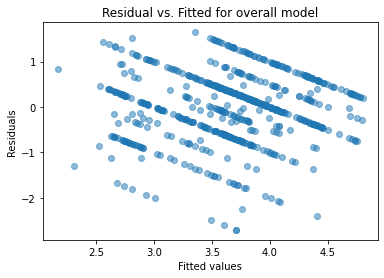

In [25]:
plt.scatter(overall_model.fittedvalues - overall_model.resid, overall_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for overall model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

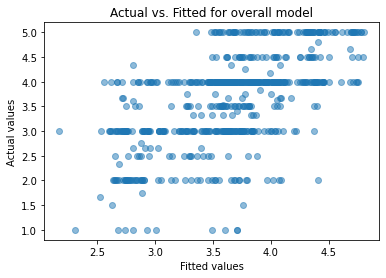

In [23]:
plt.scatter(overall_model.fittedvalues, prelockdownData["overall"], alpha=0.5)
plt.title("Actual vs. Fitted for overall model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## `Natural` model


In [ ]:
Natural_model, Natural_back, Natural_foward, Natural_vif = mlm_model_building(prelockdownData, "Natural", acoustic_vars, "LocationID", criterion="aic", check_vif = True, max_vif = 10, verbose=False)


In [ ]:
plt.scatter(Natural_model.fittedvalues - Natural_model.resid, Natural_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for Natural model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.scatter(Natural_model.fittedvalues, prelockdownData["Natural"], alpha=0.5)
plt.title("Actual vs. Fitted for Natural model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## `Traffic` model


In [ ]:
Traffic_model, Traffic_back, Traffic_foward, Traffic_vif = mlm_model_building(prelockdownData, "Traffic", acoustic_vars, "LocationID", criterion = "aic", check_vif = True, max_vif = 10, verbose=False)


In [ ]:
plt.scatter(Traffic_model.fittedvalues - Traffic_model.resid, Traffic_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for Traffic model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.scatter(Traffic_model.fittedvalues, prelockdownData["Traffic"], alpha=0.5)
plt.title("Actual vs. Fitted for Traffic model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## `Human` Model

In [ ]:
Human_model, Human_back, Human_foward, Human_vif = mlm_model_building(prelockdownData, "Human", acoustic_vars, "LocationID", criterion="aic", check_vif = True, max_vif = 10, verbose=False) 


In [ ]:
plt.scatter(Human_model.fittedvalues - Human_model.resid, Human_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for Human model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.scatter(Human_model.fittedvalues, prelockdownData["Human"], alpha=0.5)
plt.title("Actual vs. Fitted for Human model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## `Other` model

In [ ]:
Other_model, Other_back, Other_foward, Other_vif = mlm_model_building(prelockdownData, "Other", acoustic_vars, "LocationID", criterion="aic", check_vif = True, max_vif = 10, verbose=False)

In [ ]:
plt.scatter(Other_model.fittedvalues - Other_model.resid, Other_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for Other model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.scatter(Other_model.fittedvalues, prelockdownData["Other"], alpha=0.5)
plt.title("Actual vs. Fitted for Other model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## `Pleasant` model


In [ ]:
Pleasant_model, Pleasant_back, Pleasant_forward, Pleasant_vif = mlm_model_building(prelockdownData, "Pleasant", acoustic_vars, "LocationID", criterion="aic", verbose=False)


In [ ]:
plt.scatter(Pleasant_model.fittedvalues - Pleasant_model.resid, Pleasant_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for Pleasant model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.scatter(Pleasant_model.fittedvalues, prelockdownData["Pleasant"], alpha=0.5)
plt.title("Actual vs. Fitted for Pleasant model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## `Eventful` model


In [ ]:
Eventful_model, Eventful_back, Eventful_forward, Eventful_vif = mlm_model_building(prelockdownData, "Eventful", acoustic_vars, "LocationID", sig_level = 0.05, criterion="aic", verbose=False)

In [ ]:
plt.scatter(Eventful_model.fittedvalues - Eventful_model.resid, Eventful_model.resid, alpha=0.5)
plt.title("Residual vs. Fitted for Eventful model")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
plt.scatter(Eventful_model.fittedvalues, prelockdownData["Eventful"], alpha=0.5)
plt.title("Actual vs. Fitted for Eventful model")
plt.xlabel("Fitted values")
plt.ylabel("Actual values")
plt.show()

## Use the models to predict the values for the during lockdown data

In [ ]:
lockdownData["Loudness_pred"] = Loudness_model.predict(lockdownData)
lockdownData["overall_pred"] = overall_model.predict(lockdownData)
lockdownData["Natural_pred"] = Natural_model.predict(lockdownData)
lockdownData["Traffic_pred"] = Traffic_model.predict(lockdownData)
lockdownData["Human_pred"] = Human_model.predict(lockdownData)
lockdownData["Other_pred"] = Other_model.predict(lockdownData)
lockdownData["Pleasant_pred"] = Pleasant_model.predict(lockdownData)
lockdownData["Eventful_pred"] = Eventful_model.predict(lockdownData)

import seaborn as sns
l = sns.pairplot(x_vars=["Pleasant_pred"], y_vars=["Eventful_pred"], data = lockdownData, hue ="LocationID", size = 8)
l.set(xlim = (-1,1))
l.set(ylim= (-1,1))

In [ ]:
p = sns.pairplot(x_vars=["Pleasant"], y_vars=["Eventful"], data = prelockdownData, hue ="LocationID", size = 8)
p.set(xlim = (-1,1))
p.set(ylim= (-1,1))

In [ ]:
prelockdownData["Loudness_pred"] = Loudness_model.predict(prelockdownData)
prelockdownData["overall_pred"] = overall_model.predict(prelockdownData)
prelockdownData["Natural_pred"] = Natural_model.predict(prelockdownData)
prelockdownData["Traffic_pred"] = Traffic_model.predict(prelockdownData)
prelockdownData["Human_pred"] = Human_model.predict(prelockdownData)
prelockdownData["Other_pred"] = Other_model.predict(prelockdownData)
prelockdownData["Pleasant_pred"] = Pleasant_model.predict(prelockdownData)
prelockdownData["Eventful_pred"] = Eventful_back.predict(prelockdownData)

p = sns.pairplot(x_vars=["Pleasant_pred"], y_vars=["Eventful_pred"], data = prelockdownData, hue ="LocationID", size = 8)
p.set(xlim = (-1,1))
p.set(ylim= (-1,1))

## Prediction summary


In [ ]:
prelockdownSummary = prelockdownData[["LocationID", "Loudness", "Loudness_pred", "Eventful", "Eventful_pred", "Pleasant", "Pleasant_pred", "overall", "overall_pred", "Natural", "Natural_pred", "Traffic", "Traffic_pred", "Human", "Human_pred", "Other", "Other_pred"]].groupby(['LocationID']).mean()
prelockdownSummary['LocationID'] = prelockdownSummary.index
prelockdownSummary

In [ ]:
lockdownSummary = lockdownData[["LocationID", "Loudness", "Eventful_pred", "Pleasant_pred", "overall_pred", "Natural_pred", "Traffic_pred", "Human_pred", "Other_pred"]].groupby(['LocationID']).mean()
lockdownSummary['LocationID']  = lockdownSummary.index
lockdownSummary

In [ ]:
print("Loudness Difference")
print(lockdownSummary["Loudness_pred"] - prelockdownSummary["Loudness"])
print("\nPleasant Difference")
print(lockdownSummary["Pleasant_pred"] - prelockdownSummary["Pleasant"])
print("\nEventful Difference")
print(lockdownSummary["Eventful_pred"] - prelockdownSummary["Eventful"])
print("\noverall Difference")
print(lockdownSummary["overall_pred"] - prelockdownSummary["overall"])
print("\nNatural Difference")
print(lockdownSummary["Natural_pred"] - prelockdownSummary["Natural"])
print("\nTraffic Difference")
print(lockdownSummary["Traffic_pred"] - prelockdownSummary["Traffic"])
print("\nHuman Difference")
print(lockdownSummary["Human_pred"] - prelockdownSummary["Human"])
print("\nOther Difference")
print(lockdownSummary["Other_pred"] - prelockdownSummary["Other"])


In [ ]:
ls = sns.pairplot(x_vars=["Pleasant_pred"], y_vars=["Eventful_pred"], data = lockdownSummary, hue="LocationID", size = 8)
ls.set(xlim = (-1,1))
ls.set(ylim= (-1,1))

In [ ]:
ps = sns.pairplot(x_vars=["Pleasant"], y_vars=["Eventful"], data = prelockdownSummary, hue="LocationID", size = 8)
ps.set(xlim = (-1,1))
ps.set(ylim= (-1,1))

In [ ]:
ps = sns.pairplot(x_vars=["Pleasant_pred"], y_vars=["Eventful_pred"], data = prelockdownSummary, hue="LocationID", size = 8)
ps.set(xlim = (-1,1))
ps.set(ylim= (-1,1))